In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np

#NN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.python.client import device_lib

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dty

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4630870314222368232
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7129487770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17155688888433948696
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
def saveModel(directory_name, model, history):
    with open(directory_name + '_History.pkl', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    model.save(directory_name + "_Model.h5")

## Load One Image (Example MGZ)

(256, 256)
<class 'numpy.float64'>


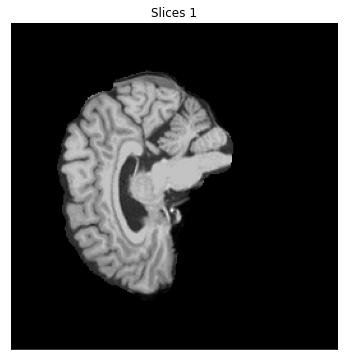

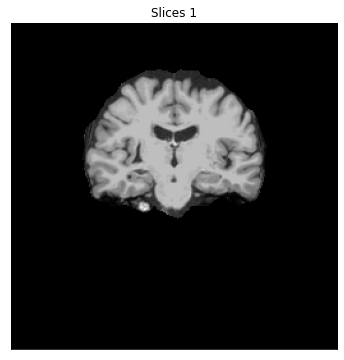

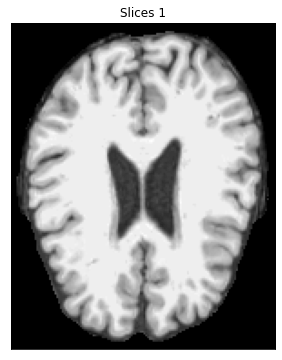

(180, 146)


In [5]:
#file = nib.load("Brain_skull removed/IXI050-Guys-0711-T1.nii.gz")
file = nib.load("Brain_skull removed/brain_Copy.mgz")

img = file.get_fdata()

slice_1 = img[122, :, :]
slice_2 = img[:, 86, :]
slice_3 = img[:, :, 125]

print(slice_1.shape)
print(type(slice_1[128, 140]))

plt.rcParams['figure.figsize'] = [12, 6]

#Sagittal Plane
showImage(slice_1.T, "Slices 1")

#Coronial Plane
showImage(slice_3.T, "Slices 1")
#Axial Plane
cut = slice_2.T[36:-40, 55:-55]
showImage(cut, "Slices 1")
print(cut.shape)

## Grouping Files into Datasets

In [6]:
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"

In [7]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [8]:
# File setup check
print("Total training AD: ", len(os.listdir(base_path+"1-Train/AD")))
print("Total validation AD: ", len(os.listdir(base_path+"2-Validation/AD")))
print("Total testing AD: ", len(os.listdir(base_path+"3-Test/AD")))

print("\nTotal training CN: ", len(os.listdir(base_path+"1-Train/CN")))
print("Total validation CN: ", len(os.listdir(base_path+"2-Validation/CN")))
print("Total testing CN: ", len(os.listdir(base_path+"3-Test/CN")))

Total training AD:  196
Total validation AD:  97
Total testing AD:  97

Total training CN:  359
Total validation CN:  178
Total testing CN:  178


### Data Preprosessing

In [9]:
# Build from directory dataset generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    base_path+"1-Train/",
    target_size=(256,256),
    batch_size=20,
    color_mode='grayscale',
    class_mode="binary")

validation_generator = test_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=20,
    color_mode='grayscale',
    class_mode="binary")

test_generator = test_datagen.flow_from_directory(
    base_path+"3-Test/",
    target_size=(256,256),
    batch_size=20,
    color_mode='grayscale',
    class_mode="binary")

Found 555 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


In [10]:
# Check batches shape
for batch, label in train_generator:
    print("data batch shape: ", batch.shape)
    print("label shape: ", label.shape)
    break

data batch shape:  (20, 256, 256, 1)
label shape:  (20,)


## Construct MNIST Model - 2 Con Max, 1 Con, 2 Dense

In [11]:
#Construct Model Convolution Layers
mnist_model = models.Sequential()
mnist_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 1)))
mnist_model.add(layers.MaxPool2D((2,2)))
mnist_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
mnist_model.add(layers.MaxPool2D((2,2)))
mnist_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
mnist_model.add(layers.Flatten())
mnist_model.add(layers.Dense(64, activation = 'relu'))
mnist_model.add(layers.Dense(1, activation = 'sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [13]:
mnist_model.compile(loss="binary_crossentropy",
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting and Saving Model

In [14]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/MNIST/MNIST_Basic/"

In [15]:
checkpoint = ModelCheckpoint(filepath=base_directory+"weights.{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True)

model_history = mnist_model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    callbacks=[checkpoint],
    validation_data=validation_generator,
    validation_steps=50)

mnist_model_history = model_history.history

saveModel(base_directory + 'mnist', mnist_model, mnist_model_history)

Epoch 1/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6130 - acc: 0.6806 - val_loss: 0.5778 - val_acc: 0.7056
Epoch 2/30
100/100 [==============================] - 6s 60ms/step - loss: 0.3301 - acc: 0.8758 - val_loss: 0.5763 - val_acc: 0.7452
Epoch 3/30
100/100 [==============================] - 6s 57ms/step - loss: 0.1039 - acc: 0.9747 - val_loss: 0.7845 - val_acc: 0.7310
Epoch 4/30
100/100 [==============================] - 6s 58ms/step - loss: 0.0420 - acc: 0.9854 - val_loss: 1.0323 - val_acc: 0.7086
Epoch 5/30
100/100 [==============================] - 6s 57ms/step - loss: 0.0222 - acc: 0.9935 - val_loss: 1.0682 - val_acc: 0.7381
Epoch 6/30
100/100 [==============================] - 6s 57ms/step - loss: 0.0156 - acc: 0.9970 - val_loss: 1.2377 - val_acc: 0.7442
Epoch 7/30
100/100 [==============================] - 6s 57ms/step - loss: 0.0135 - acc: 0.9934 - val_loss: 1.3523 - val_acc: 0.7066
Epoch 8/30
100/100 [==============================] - 6s 57ms/step - 

### Retrieving Saved Model and History

In [16]:
with open(base_directory + 'mnist_History.pkl', 'rb') as file__pi:
    mnist_model_history = pickle.load(file__pi)

mnist_best = models.load_model(base_directory+"weights.01-0.58.hdf5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Plotting Results

In [17]:
# Accuracy Plots
accuracy = mnist_model_history['acc']
validation_accuracy = mnist_model_history['val_acc']
loss = mnist_model_history['loss']
validation_loss = mnist_model_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc: 
 1.0
train_loss: 
 4.61269581197854e-09

valid_acc: 
 0.7147208
valid_loss: 
 3.029255311489105

test_acc: 
 0.68832487
test_loss: 
 2.9579182481765747

best_acc: 
 0.6395939
best_loss: 
 0.6292617040872573


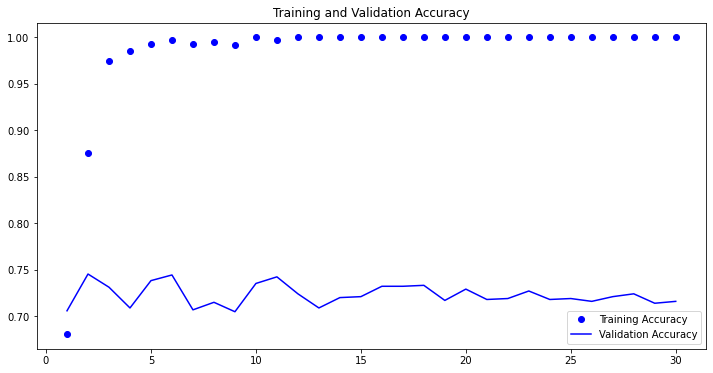

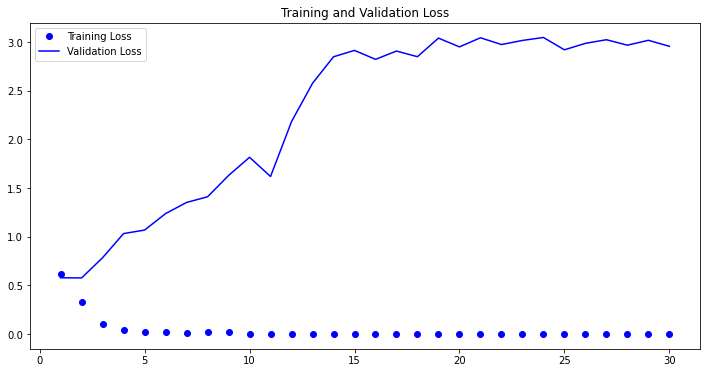

<Figure size 864x432 with 0 Axes>

In [18]:
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc = mnist_model.evaluate_generator(train_generator, steps=50)
print("\ntrain_acc: \n", train_acc)
print("train_loss: \n", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc = mnist_model.evaluate_generator(validation_generator, steps=50)
print("\nvalid_acc: \n", valid_acc)
print("valid_loss: \n", valid_loss)

# Generate acc loss percentages
test_loss, test_acc = mnist_model.evaluate_generator(test_generator, steps=50)
print("\ntest_acc: \n", test_acc)
print("test_loss: \n", test_loss)

# Output best epoch acc loss percentages
best_loss, best_acc = mnist_best.evaluate_generator(test_generator, steps=50)
print("\nbest_acc: \n", best_acc)
print("best_loss: \n", best_loss)

## Construct (4 Con Max, 2 Dense) Model

In [19]:
#Construct Model Convolution Layers
bigger_model = models.Sequential()
bigger_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 1)))
bigger_model.add(layers.MaxPool2D((2,2)))
bigger_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
bigger_model.add(layers.MaxPool2D((2,2)))
bigger_model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
bigger_model.add(layers.MaxPool2D((2,2)))
bigger_model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
bigger_model.add(layers.MaxPool2D((2,2)))
bigger_model.add(layers.Flatten())
bigger_model.add(layers.Dense(128, activation = 'relu'))
bigger_model.add(layers.Dense(1, activation = 'sigmoid'))

In [20]:
bigger_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)      

In [21]:
bigger_model.compile(loss="binary_crossentropy",
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

### Fitting and Saving Model

In [22]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/MNIST/MNIST_Mid/"

In [23]:
checkpoint = ModelCheckpoint(filepath=base_directory+"weights.{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True)

model_history= bigger_model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    callbacks=[checkpoint],
    validation_data=validation_generator,
    validation_steps=50)

bigger_model_history = model_history.history

saveModel(base_directory + 'bigger_model', bigger_model, bigger_model_history)

Epoch 1/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6315 - acc: 0.6529 - val_loss: 0.6365 - val_acc: 0.7269
Epoch 2/30
100/100 [==============================] - 6s 57ms/step - loss: 0.5581 - acc: 0.7227 - val_loss: 0.5285 - val_acc: 0.7665
Epoch 3/30
100/100 [==============================] - 6s 57ms/step - loss: 0.4471 - acc: 0.8101 - val_loss: 0.4743 - val_acc: 0.7746
Epoch 4/30
100/100 [==============================] - 6s 56ms/step - loss: 0.3739 - acc: 0.8363 - val_loss: 0.4986 - val_acc: 0.7462
Epoch 5/30
100/100 [==============================] - 5s 54ms/step - loss: 0.2899 - acc: 0.8778 - val_loss: 0.5116 - val_acc: 0.7736
Epoch 6/30
100/100 [==============================] - 6s 56ms/step - loss: 0.2113 - acc: 0.9219 - val_loss: 0.6158 - val_acc: 0.7025
Epoch 7/30
100/100 [==============================] - 6s 57ms/step - loss: 0.1480 - acc: 0.9439 - val_loss: 0.6608 - val_acc: 0.7411
Epoch 8/30
100/100 [==============================] - 6s 57ms/step - 

### Retrieving Saved Model and History

In [25]:
with open(base_directory + 'bigger_model_history.pkl', 'rb') as file__pi:
    bigger_model_history = pickle.load(file__pi)

bigger_model_best = models.load_model(base_directory+"weights.03-0.47.hdf5")

### Plotting Results

In [26]:
accuracy = bigger_model_history['acc']
validation_accuracy = bigger_model_history['val_acc']
loss = bigger_model_history['loss']
validation_loss = bigger_model_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc: 
 1.0
train_loss: 
 3.4778563900772497e-07

valid_acc: 
 0.7167513
valid_loss: 
 2.486619951725006

test_acc: 
 0.6751269
test_loss: 
 2.717530697584152

best_acc: 
 0.7451777
best_loss: 
 0.5149178266525268


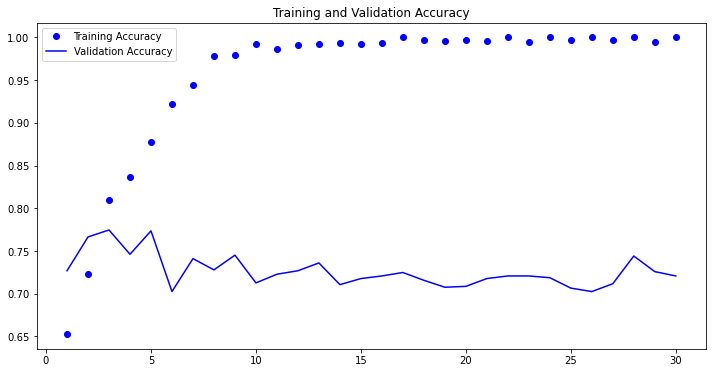

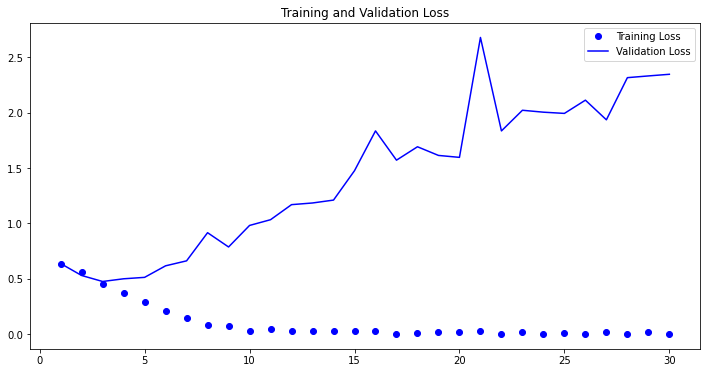

<Figure size 864x432 with 0 Axes>

In [27]:
# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc = bigger_model.evaluate_generator(train_generator, steps=50)
print("\ntrain_acc: \n", train_acc)
print("train_loss: \n", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc = bigger_model.evaluate_generator(validation_generator, steps=50)
print("\nvalid_acc: \n", valid_acc)
print("valid_loss: \n", valid_loss)

# Generate acc loss percentages
test_loss, test_acc = bigger_model.evaluate_generator(test_generator, steps=50)
print("\ntest_acc: \n", test_acc)
print("test_loss: \n", test_loss)

# Output best epoch acc loss percentages
best_loss, best_acc = bigger_model_best.evaluate_generator(test_generator, steps=50)
print("\nbest_acc: \n", best_acc)
print("best_loss: \n", best_loss)

 ## Construct (6 Con Max, 2 Dense) Model

In [28]:
#Construct Model Convolution Layers
model_6ConMax = models.Sequential()
model_6ConMax.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 1)))
model_6ConMax.add(layers.MaxPool2D((2,2)))
model_6ConMax.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_6ConMax.add(layers.MaxPool2D((2,2)))
model_6ConMax.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model_6ConMax.add(layers.MaxPool2D((2,2)))
model_6ConMax.add(layers.Conv2D(512, (3, 3), activation = 'relu'))
model_6ConMax.add(layers.MaxPool2D((2,2)))
model_6ConMax.add(layers.Conv2D(1024, (3, 3), activation = 'relu'))
model_6ConMax.add(layers.MaxPool2D((2,2)))
model_6ConMax.add(layers.Conv2D(1024, (3, 3), activation = 'relu'))
model_6ConMax.add(layers.MaxPool2D((2,2)))
model_6ConMax.add(layers.Flatten())
model_6ConMax.add(layers.Dense(1024, activation = 'relu'))
model_6ConMax.add(layers.Dense(1, activation = 'sigmoid'))

In [29]:
model_6ConMax.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 512)      

In [30]:
model_6ConMax.compile(loss="binary_crossentropy",
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

### Fitting and Saving Model

In [31]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/MNIST/MNIST_6ConMax/"

In [32]:
checkpoint = ModelCheckpoint(filepath=base_directory+"weights.{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True)

model_history= model_6ConMax.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    callbacks=[checkpoint],
    validation_data=validation_generator,
    validation_steps=50)

# Use only .history for easy storage
model_6ConMax_history = model_history.history

saveModel(base_directory + 'model_6ConMax', model_6ConMax, model_6ConMax_history)

Epoch 1/30
100/100 [==============================] - 13s 128ms/step - loss: 0.6548 - acc: 0.6418 - val_loss: 0.6351 - val_acc: 0.6893
Epoch 2/30
100/100 [==============================] - 10s 105ms/step - loss: 0.5525 - acc: 0.7131 - val_loss: 0.5132 - val_acc: 0.7553
Epoch 3/30
100/100 [==============================] - 10s 103ms/step - loss: 0.3543 - acc: 0.8384 - val_loss: 0.5241 - val_acc: 0.7330
Epoch 4/30
100/100 [==============================] - 10s 102ms/step - loss: 0.1617 - acc: 0.9375 - val_loss: 0.6157 - val_acc: 0.7685
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.0636 - acc: 0.9783 - val_loss: 0.7269 - val_acc: 0.7726
Epoch 6/30
100/100 [==============================] - 10s 101ms/step - loss: 0.0212 - acc: 0.9935 - val_loss: 1.2850 - val_acc: 0.7574
Epoch 7/30
100/100 [==============================] - 10s 101ms/step - loss: 0.0121 - acc: 0.9960 - val_loss: 1.1921 - val_acc: 0.7553
Epoch 8/30
100/100 [==============================] - 1

### Retrieving Saved Model and History

In [35]:
with open(base_directory + 'model_6ConMax_History.pkl', 'rb') as file__pi:
    model_6ConMax_history = pickle.load(file__pi)
    
model_6ConMax_best = models.load_model(base_directory+"weights.02-0.51.hdf5")

### Plotting Results

In [36]:
accuracy = model_6ConMax_history['acc']
validation_accuracy = model_6ConMax_history['val_acc']
loss = model_6ConMax_history['loss']
validation_loss = model_6ConMax_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc: 
 1.0
train_loss: 
 3.6402243730471186e-09

valid_acc: 
 0.7857868
valid_loss: 
 2.270711314789951

test_acc: 
 0.76243657
test_loss: 
 2.6839173471927644

best_acc: 
 0.74822336
best_loss: 
 0.5460203468799592


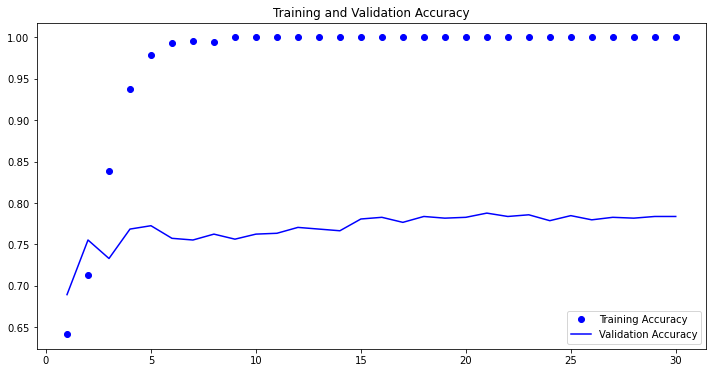

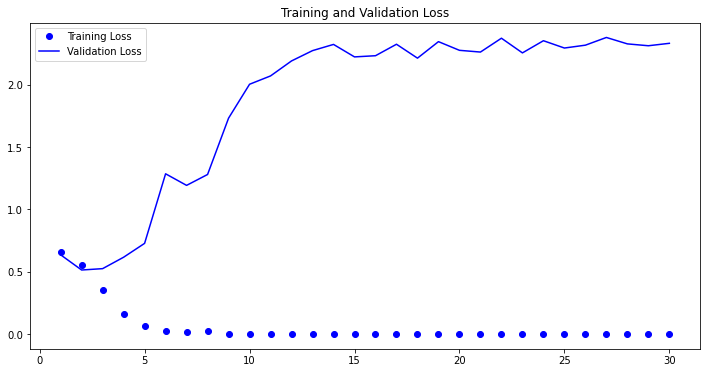

<Figure size 864x432 with 0 Axes>

In [37]:
# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc = model_6ConMax.evaluate_generator(train_generator, steps=50)
print("\ntrain_acc: \n", train_acc)
print("train_loss: \n", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc = model_6ConMax.evaluate_generator(validation_generator, steps=50)
print("\nvalid_acc: \n", valid_acc)
print("valid_loss: \n", valid_loss)

# Generate acc loss percentages
test_loss, test_acc = model_6ConMax.evaluate_generator(test_generator, steps=50)
print("\ntest_acc: \n", test_acc)
print("test_loss: \n", test_loss)

# Output best epoch acc loss percentages
best_loss, best_acc = model_6ConMax_best.evaluate_generator(test_generator, steps=50)
print("\nbest_acc: \n", best_acc)
print("best_loss: \n", best_loss)

 ## Construct Basic VGG16 Model

In [38]:
# Construct model
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Feature Extraction

In [39]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    
    # Create batch generator
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')
    
    # Run batches through conv. and save in features in order
    i = 0
    for batch_input, batch_labels in generator:
        batch_features = conv_base.predict(batch_input)
        features[i * batch_size : (i + 1) * batch_size] = batch_features
        labels[i * batch_size : (i + 1) * batch_size] = batch_labels
        
        i += 1
        if (i * batch_size >= sample_count):
            break
    return features, labels

train_features, train_labels = extract_features(base_path+"1-Train/", 555)
validation_features, validation_labels = extract_features(base_path+"2-Validation/", 275)
test_features, test_labels = extract_features(base_path+"3-Test/", 275)

Found 555 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


In [40]:
train_features = np.reshape(train_features, (555, 8 * 8 * 512))
validation_features = np.reshape(validation_features, (275, 8 * 8 * 512))
test_features = np.reshape(test_features, (275, 8 * 8 * 512))

### Building Model

In [41]:
VGG16_Class_Model = models.Sequential()
VGG16_Class_Model.add(layers.Dense(256, activation='relu', input_dim=8 * 8 * 512))
VGG16_Class_Model.add(layers.Dropout(0.5))
VGG16_Class_Model.add(layers.Dense(1, activation='sigmoid'))

VGG16_Class_Model.summary()

VGG16_Class_Model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                         loss='binary_crossentropy',
                         metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


### Fitting and Saving Conv. Features

In [42]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/VGG16_Basic/"

In [43]:
checkpoint = ModelCheckpoint(filepath=base_directory+"weights.{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True)

VGG16_model_history = VGG16_Class_Model.fit(train_features, train_labels,
    epochs=30,
    callbacks=[checkpoint],
    batch_size=20,
    validation_data=(validation_features, validation_labels))

VGG16_history = VGG16_model_history.history

saveModel(base_directory + 'VGG16_class', VGG16_Class_Model, VGG16_history)

Train on 555 samples, validate on 275 samples
Epoch 1/30
555/555 [==============================] - 1s 2ms/sample - loss: 0.7177 - acc: 0.5982 - val_loss: 0.6443 - val_acc: 0.6727
Epoch 2/30
555/555 [==============================] - 1s 901us/sample - loss: 0.6302 - acc: 0.6523 - val_loss: 0.6013 - val_acc: 0.6545
Epoch 3/30
555/555 [==============================] - 0s 845us/sample - loss: 0.6290 - acc: 0.6450 - val_loss: 0.5906 - val_acc: 0.7418
Epoch 4/30
555/555 [==============================] - 0s 732us/sample - loss: 0.5855 - acc: 0.6901 - val_loss: 0.6277 - val_acc: 0.6764
Epoch 5/30
555/555 [==============================] - 0s 845us/sample - loss: 0.5547 - acc: 0.7153 - val_loss: 0.5779 - val_acc: 0.7636
Epoch 6/30
555/555 [==============================] - 0s 734us/sample - loss: 0.5406 - acc: 0.7333 - val_loss: 0.5924 - val_acc: 0.6582
Epoch 7/30
555/555 [==============================] - 0s 899us/sample - loss: 0.5165 - acc: 0.7658 - val_loss: 0.5534 - val_acc: 0.7091
Epoc

### Retrieving Saved Model and History

In [44]:
with open(base_directory + 'VGG16_class_history.pkl', 'rb') as file__pi:
    VGG16_history = pickle.load(file__pi)
    
VGG16_best = models.load_model(base_directory+"weights.25-0.50.hdf5")

### Plotting Results

In [45]:
accuracy = VGG16_history['acc']
validation_accuracy = VGG16_history['val_acc']
loss = VGG16_history['loss']
validation_loss = VGG16_history['val_loss']

epochs = range(1, len(accuracy) + 1)

50/50 [==============================] - 2s 50ms/step - loss: 0.2523 - acc: 0.9514
train_acc: 
 0.95135134
train_loss: 
 0.2522924542427063
50/50 [==============================] - 1s 25ms/step - loss: 0.4996 - acc: 0.7636

valid_acc: 
 0.76363635
valid_loss: 
 0.4995850622653961
50/50 [==============================] - 1s 26ms/step - loss: 0.4969 - acc: 0.7927

test_acc: 
 0.7927273
test_loss: 
 0.49690040946006775
50/50 [==============================] - 1s 27ms/step - loss: 0.5105 - acc: 0.7782

test_acc: 
 0.7781818
test_loss: 
 0.5105217099189758


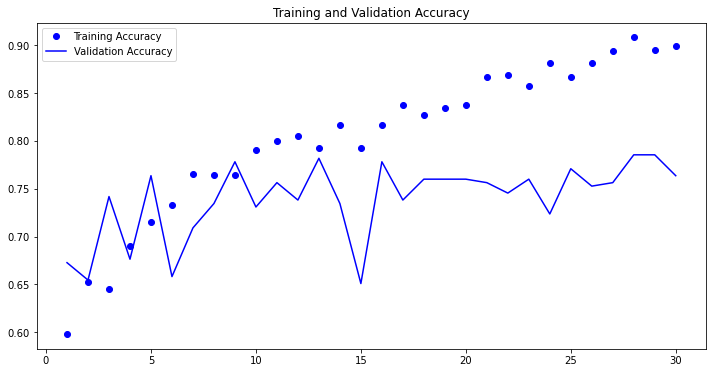

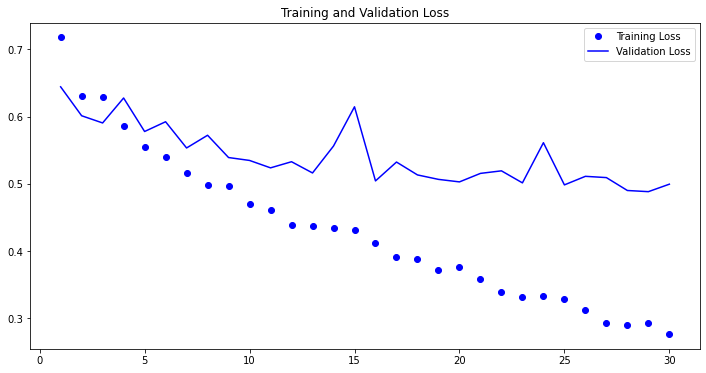

<Figure size 864x432 with 0 Axes>

In [46]:
# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc = VGG16_Class_Model.evaluate(train_features, train_labels, batch_size = 20, steps=50)
print("train_acc: \n", train_acc)
print("train_loss: \n", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc = VGG16_Class_Model.evaluate(validation_features, validation_labels, batch_size = 20, steps=50)
print("\nvalid_acc: \n", valid_acc)
print("valid_loss: \n", valid_loss)

# Generate acc loss percentages
test_loss, test_acc = VGG16_Class_Model.evaluate(test_features, test_labels, batch_size = 20, steps=50)
print("\ntest_acc: \n", test_acc)
print("test_loss: \n", test_loss)

# Generate acc loss percentages
test_loss, test_acc = VGG16_best.evaluate(test_features, test_labels, batch_size = 20, steps=50)
print("\ntest_acc: \n", test_acc)
print("test_loss: \n", test_loss)